In [68]:
#Load libraries
import numpy as np
from sklearn import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from scipy import stats

In [69]:
iris = load_iris()
type(iris)

sklearn.utils.Bunch

In [70]:
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


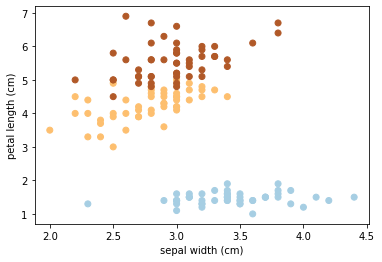

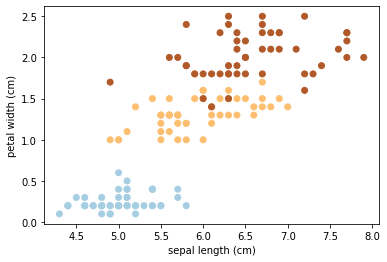

In [71]:
plt.scatter(iris.data[:,1],iris.data[:,2],c=iris.target, cmap=plt.cm.Paired)
plt.xlabel(iris.feature_names[1])
plt.ylabel(iris.feature_names[2])
plt.show()

plt.scatter(iris.data[:,0],iris.data[:,3],c=iris.target, cmap=plt.cm.Paired)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[3])
plt.show()

In [72]:
X = iris.data
Y = iris.target

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=7)

In [75]:
neighbors=np.arange(1,7)
train_accuracy=np.empty(len(neighbors))
test_accuracy=np.empty(len(neighbors))

In [76]:
from sklearn.utils.extmath import weighted_mode
from sklearn.utils.validation import _is_arraylike, _num_samples
import warnings
from sklearn.neighbors._base import _check_weights, _get_weights
from sklearn.neighbors._base import NeighborsBase, KNeighborsMixin, RadiusNeighborsMixin
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import _deprecate_positional_args
from scipy.stats import mode

In [83]:
class KNN(KNeighborsMixin,
                           ClassifierMixin,
                           NeighborsBase):

    def __init__(self, n_neighbors=5, *,
                 weights='uniform', algorithm='auto', leaf_size=30,
                 p=2, metric='minkowski', metric_params=None, n_jobs=None):
        super().__init__(
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            leaf_size=leaf_size, metric=metric, p=p,
            metric_params=metric_params,
            n_jobs=n_jobs)
        self.weights = _check_weights(weights)

    def fit(self, X, y):
        return self._fit(X, y)

    def predict(self, X):
        X = self._validate_data(X, accept_sparse='csr', reset=False)

        neigh_dist, neigh_ind = self.kneighbors(X)
        classes_ = self.classes_
        _y = self._y
        if not self.outputs_2d_:
            _y = self._y.reshape((-1, 1))
            classes_ = [self.classes_]

        n_outputs = len(classes_)
        n_queries = _num_samples(X)
        weights = _get_weights(neigh_dist, self.weights)

        y_pred = np.empty((n_queries, n_outputs), dtype=classes_[0].dtype)
        for k, classes_k in enumerate(classes_):
            if weights is None:
                mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
            else:
                mode, _ = weighted_mode(_y[neigh_ind, k], weights, axis=1)

            mode = np.asarray(mode.ravel(), dtype=np.intp)
            y_pred[:, k] = classes_k.take(mode)

        if not self.outputs_2d_:
            y_pred = y_pred.ravel()

        return y_pred
    #Euclidean Distance
    def eucledian(p1,p2):
        dist = np.sqrt(np.sum((p1-p2)**2))
        return dist
    def predicts(x_train, y , x_input, k):
        op_labels = []

        #Loop through the Datapoints to be classified
        for item in x_input: 

            #Array to store distances
            point_dist = []

            #Loop through each training Data
            for j in range(len(x_train)): 
                distances = eucledian(np.array(x_train[j,:]) , item) 
                #Calculating the distance
                point_dist.append(distances) 
            point_dist = np.array(point_dist) 

            #Sorting the array while preserving the index
            #Keeping the first K datapoints
            dist = np.argsort(point_dist)[:k] 

            #Labels of the K datapoints from above
            labels = y[dist]

            #Majority voting
            lab = mode(labels) 
            lab = lab.mode[0]
            op_labels.append(lab)
        return op_labels

    def predict_proba(self, X):
        X = self._validate_data(X, accept_sparse='csr', reset=False)

        neigh_dist, neigh_ind = self.kneighbors(X)

        classes_ = self.classes_
        _y = self._y
        if not self.outputs_2d_:
            _y = self._y.reshape((-1, 1))
            classes_ = [self.classes_]

        n_queries = _num_samples(X)

        weights = _get_weights(neigh_dist, self.weights)
        if weights is None:
            weights = np.ones_like(neigh_ind)

        all_rows = np.arange(X.shape[0])
        probabilities = []
        for k, classes_k in enumerate(classes_):
            pred_labels = _y[:, k][neigh_ind]
            proba_k = np.zeros((n_queries, classes_k.size))

            # a simple ':' index doesn't work right
            for i, idx in enumerate(pred_labels.T):  # loop is O(n_neighbors)
                proba_k[all_rows, idx] += weights[:, i]

            # normalize 'votes' into real [0,1] probabilities
            normalizer = proba_k.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0
            proba_k /= normalizer

            probabilities.append(proba_k)

        if not self.outputs_2d_:
            probabilities = probabilities[0]

        return probabilities


In [84]:
from sklearn import metrics

In [85]:
neighbors=np.arange(1,9)
train_accuracy=np.empty(len(neighbors))
test_accuracy=np.empty(len(neighbors))

Text(0, 0.5, 'Error (misclassification) Rate')

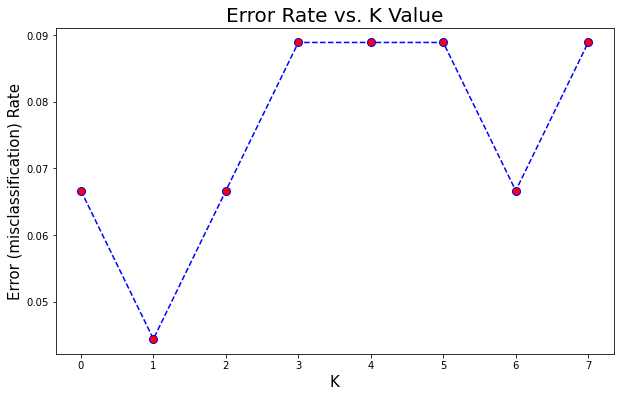

In [86]:
error_rate = []
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNN(n_neighbors=k)
    knn.fit(X_train, y_train) 
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
    # Compute traning and test data accuracy
    train_accuracy[i]=knn.score(X_train,y_train)
    test_accuracy[i]=knn.score(X_test,y_test)
plt.figure(figsize=(10,6))
plt.plot(range(0,k),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value', fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('Error (misclassification) Rate',fontsize=15)

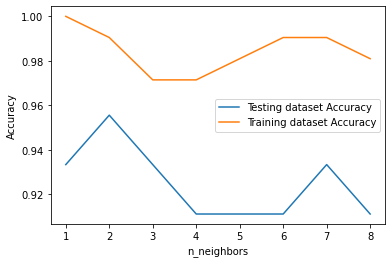

In [87]:
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [88]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [64]:
pred = predict(X_train,y_train,X_test , 9)

In [65]:
print("Accuracy : ", metrics.accuracy_score(y_test,pred)*100)
print("Report : ", metrics.classification_report(y_test,pred, labels=np.unique(pred)))

Accuracy :  93.33333333333333
Report :                precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.88      0.94      0.91        16
           2       0.94      0.88      0.91        17

    accuracy                           0.93        45
   macro avg       0.94      0.94      0.94        45
weighted avg       0.93      0.93      0.93        45



In [66]:
#0 = setosa, 1=versicolor, 2=virginica
classes = {0:'setosa',1:'versicolor',2:'virginica'}


x_new = [[3,4,5,2],
         [5,4,2,2]]
y_predict = knn.predict(x_new)

print(classes[y_predict[0]])
print(classes[y_predict[1]])

versicolor
setosa
